In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy.stats import pearsonr


# get data

In [2]:
data_dir = os.getcwd()

In [43]:
# read tables

local_auth_table = pd.read_excel(os.path.join(data_dir, "local_auth_small.xlsx"))
print(local_auth_table.shape)


(255, 4)


In [44]:
local_auth_table["total_children"] = local_auth_table["סה\"כ  אוכלוסייה בסוף השנה"]*local_auth_table["בני 17-0"]/100
local_auth_table["total_elders"] = local_auth_table["סה\"כ  אוכלוסייה בסוף השנה"]*local_auth_table["בני 65 ומעלה"]/100
local_auth_table = local_auth_table.set_index("שם  הרשות")
local_auth_table.head()

,"סה""כ אוכלוסייה בסוף השנה",בני 65 ומעלה,בני 17-0,total_children,total_elders
שם הרשות,,,,,
אום אל-פחם,56777,4.658577,36.159008,20530.0,2645.0
אופקים,32555,8.732914,36.937490,12025.0,2843.0
אור יהודה,36770,13.459342,28.264890,10393.0,4949.0
אור עקיבא,19447,14.305548,28.040315,5453.0,2782.0
אילת,52519,10.921762,24.973819,13116.0,5736.0


In [5]:
med_serv_table = pd.read_csv(os.path.join(data_dir, "med_serv_isr2.csv"), header=1).set_index("עיר")
print(med_serv_table.shape)
med_serv_table.head()

(75883, 6)


,קופת חולים,סוג שירות,סוג התמחות,שם,טלפון,כתובת
עיר,,,,,,
אבו סנאן,לאומית,שירותי סל,אורולוגיה,דר ברבארה יוסף,04-9561308,אבו סנאן
אבו סנאן,לאומית,שירותי סל,אורתופדיה,דר סעיד ראיק,04-9561308,אבו סנאן
אבו סנאן,לאומית,שירותי סל,אנדוקרינולוגיה,דר עאסלה מוסטפא,04-9561308,אבו סנאן
אבו סנאן,לאומית,שירותי סל,אף אוזן וגרון,דר סעב באסם,04-9996489,אבו סנאן
אבו סנאן,לאומית,שירותי סל,בית מרקחת,אבו סנאן,04-9969282,אבו סנאן


# long, hard-coded script:

Text(0.01, 0.99, 'Pearson r=0.961, p=0.0')

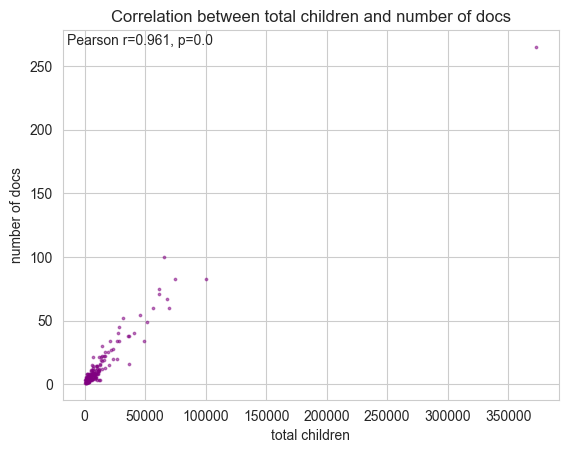

In [33]:
# write code to groupby specific profession, combine with local auth, generate a plot anc calculate pearson
profession = "ילדים"
pediatrics_table = med_serv_table[med_serv_table["סוג התמחות"]==profession]

pediatric_table_grouped = pediatrics_table.groupby("עיר").nunique()["שם"].rename("num docs")

merged_table = pd.merge(pd.DataFrame(local_auth_table["total_children"]),
                        pediatric_table_grouped,
                        how="inner", left_index=True, right_index=True)
merged_table.head()
fig, ax = plt.subplots()
ax.scatter(merged_table["total_children"], merged_table["num docs"], s=3, alpha=0.5, color="purple")
ax.set_xlabel("total children")
ax.set_ylabel("number of docs")
ax.set_title("Correlation between total children and number of docs")

r,p = pearsonr(merged_table["total_children"], merged_table["num docs"])
ax.text(0.01, 0.99, f"Pearson r={round(r,3)}, p={round(p,3)}", va="top", ha="left", transform=ax.transAxes)






Text(0.01, 0.99, 'Pearson r=0.873, p=0.0')

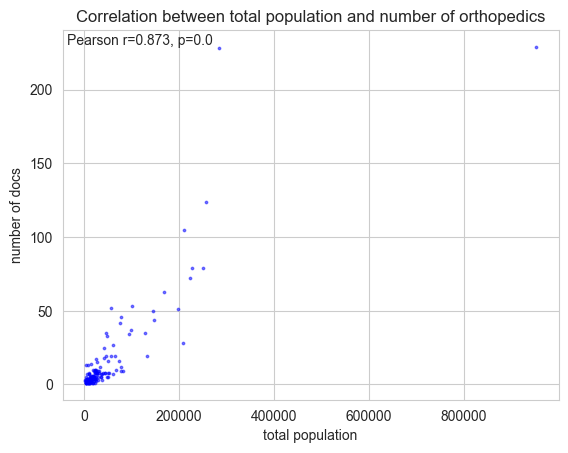

In [35]:
# repeat for another profession:
profession = "אורתופדיה" #todo changed here
pediatrics_table = med_serv_table[med_serv_table["סוג התמחות"]==profession]

pediatric_table_grouped = pediatrics_table.groupby("עיר").nunique()["שם"].rename("num docs")

merged_table = pd.merge(pd.DataFrame(local_auth_table["סה\"כ  אוכלוסייה בסוף השנה"]), #todo changed here
                        pediatric_table_grouped,
                        how="inner", left_index=True, right_index=True)
merged_table.head()
fig, ax = plt.subplots()
ax.scatter(merged_table["סה\"כ  אוכלוסייה בסוף השנה"], merged_table["num docs"], s=3, alpha=0.5, color="blue")  #todo changed here
ax.set_xlabel("total population")  #todo changed here
ax.set_ylabel("number of docs")
ax.set_title("Correlation between total population and number of orthopedics")  #todo changed here

r,p = pearsonr(merged_table["סה\"כ  אוכלוסייה בסוף השנה"], merged_table["num docs"]) #todo changed here
ax.text(0.01, 0.99, f"Pearson r={round(r,3)}, p={round(p,3)}", va="top", ha="left", transform=ax.transAxes)






# seperate into functions

In [22]:

def count_professionals_by_authority(med_serv_table, profession=None, kupa=None):
    profession_table = med_serv_table
    if profession is not None:
        profession_table = med_serv_table[med_serv_table["סוג התמחות"]==profession]
    if kupa is not None:
        profession_table = profession_table[profession_table["קופת חולים"] == kupa]
    profession_table_grouped = profession_table.groupby("עיר").nunique()["שם"].rename("num docs")
    
    return profession_table_grouped

def merge_professionals_and_population(professional_table_grouped, local_auth_table, 
                                       local_auth_population_col):

    merged_table = pd.merge(pd.DataFrame(local_auth_table[local_auth_population_col]),
                            professional_table_grouped,
                            how="inner", left_index=True, right_index=True)
    
    return merged_table

def gen_correlation_plot(merged_table, local_auth_population_col, profession=None, 
                         xlabel=None, ylabel=None, title=None, print_corr = True, ax = None, **kwargs):
    if ax is None:
        fig, ax = plt.subplots()
    
    ax.scatter(merged_table[local_auth_population_col], merged_table["num docs"], **kwargs) 
    xlabel = xlabel if xlabel is not None else local_auth_population_col
    ylabel = ylabel if ylabel is not None else "num docs"
    title = title if title is not None else f"correlation between {local_auth_population_col} and {profession}"
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    
    if print_corr:    
        r,p = pearsonr(merged_table[local_auth_population_col], merged_table["num docs"])
        ax.text(0.01, 0.99, f"Pearson r={round(r,3)}, p={round(p,3)}", va="top", ha="left", transform=ax.transAxes)
        
    return ax

def gen_med_service_correlation_plot(med_serv_table, local_auth_table,
                                     local_auth_population_col,
                                     profession=None, kupa=None,
                                     xlabel=None, ylabel=None, title=None, print_corr=True, ax=None,
                                     **plot_kwargs):
    
    professional_table_grouped = count_professionals_by_authority(med_serv_table, profession=profession,
                                                                kupa=kupa)
    
    merged_table = merge_professionals_and_population(professional_table_grouped, local_auth_table, 
                                       local_auth_population_col)
    
    ax = gen_correlation_plot(merged_table=merged_table, local_auth_population_col=local_auth_population_col,
                              profession=profession, 
                              xlabel=xlabel, ylabel=ylabel, title=title, print_corr = print_corr, ax = ax,
                              **plot_kwargs)
    
    return ax
    
    

# usage examples:

<Axes: title={'center': 'correlation between total population and tolaryngologist count'}, xlabel='total population', ylabel='num docs'>

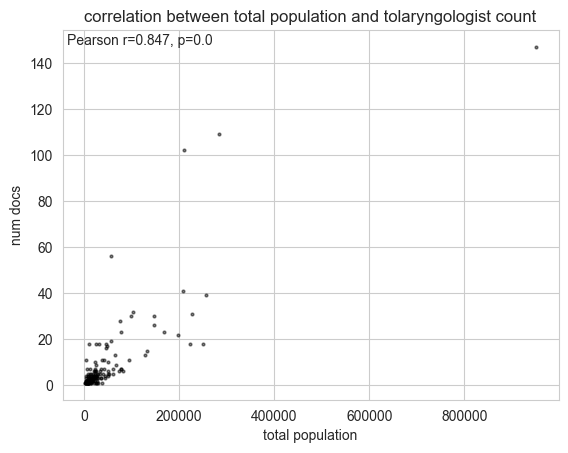

In [23]:
med_serv_table = med_serv_table
local_auth_table = local_auth_table
local_auth_population_col = "סה\"כ  אוכלוסייה בסוף השנה"
profession = "אף אוזן וגרון"
plot_kwargs = {"alpha": 0.5, "s": 4, "color": "black"}
xlabel = "total population"
ylabel = "num docs"
title = "correlation between total population and tolaryngologist count"

gen_med_service_correlation_plot(med_serv_table=med_serv_table, local_auth_table=local_auth_table,
                                local_auth_population_col=local_auth_population_col,
                                profession=profession, kupa=None,
                                     xlabel=xlabel, ylabel=ylabel, title=title, print_corr=True,
                                     **plot_kwargs)


endocrinology אנדוקרינולוגיה
lung diseases מחלות ריאה
Gastroenteres גסטרואנטרולוגיה


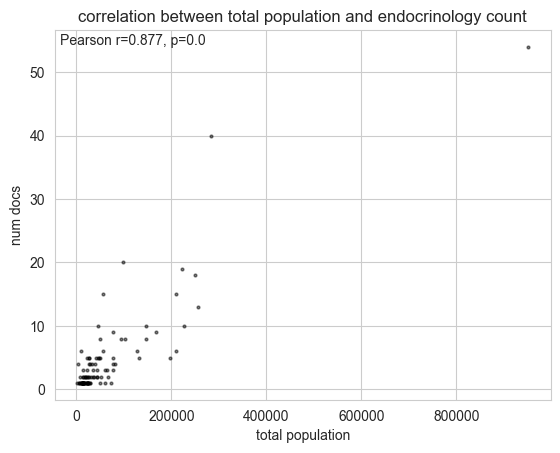

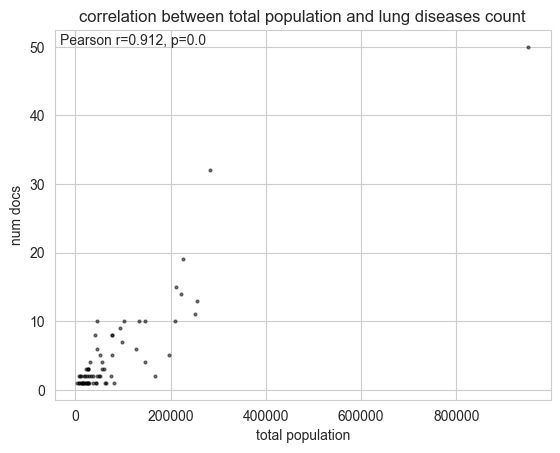

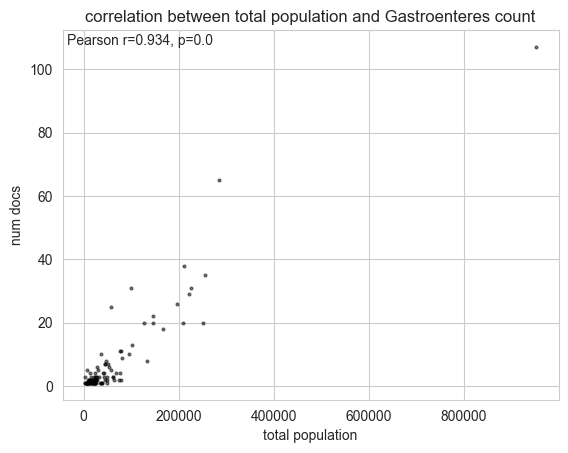

In [33]:
profession_dict = {
    "endocrinology": 'אנדוקרינולוגיה',
    "lung diseases": 'מחלות ריאה',
    "Gastroenteres":  'גסטרואנטרולוגיה'
    }

for profession_name, profession in profession_dict.items():
    fig, ax = plt.subplots()
    print(profession_name, profession)
    med_serv_table = med_serv_table
    local_auth_table = local_auth_table
    local_auth_population_col = "סה\"כ  אוכלוסייה בסוף השנה"
    profession = profession
    plot_kwargs = {"alpha": 0.5, "s": 4, "color": "black"}
    xlabel = "total population"
    ylabel = "num docs"
    title = f"correlation between total population and {profession_name} count"
    
    gen_med_service_correlation_plot(med_serv_table=med_serv_table, local_auth_table=local_auth_table,
                                    local_auth_population_col=local_auth_population_col,
                                    profession=profession, kupa=None, ax=ax,
                                         xlabel=xlabel, ylabel=ylabel, title=title, print_corr=True,
                                         **plot_kwargs)


In [42]:
local_auth_table

'total_children'

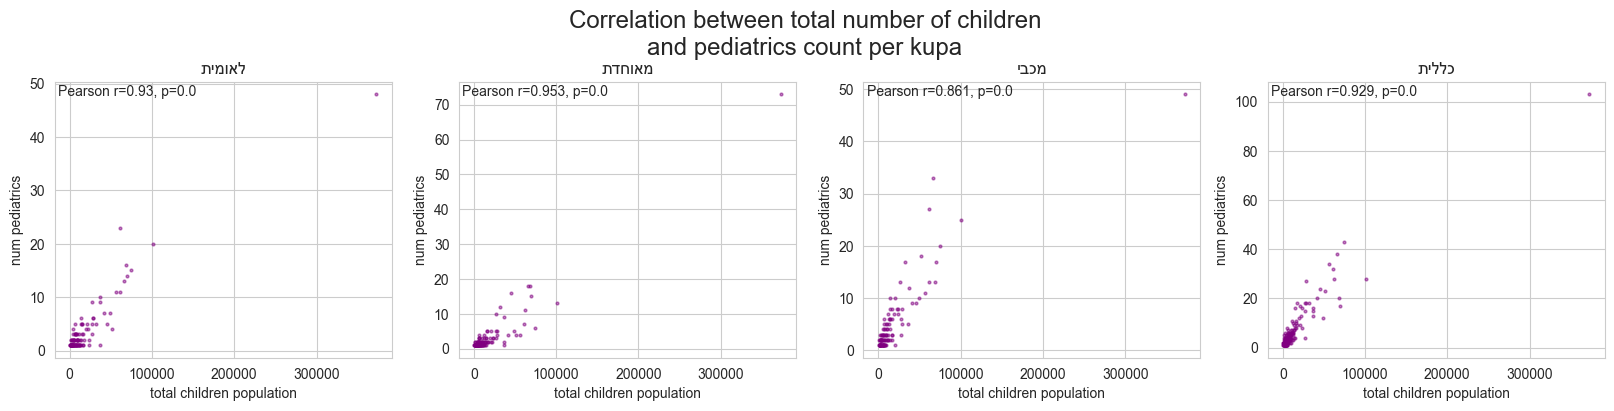

In [54]:
kupot_list = med_serv_table["קופת חולים"].unique()
profession = "ילדים"
med_serv_table = med_serv_table
local_auth_table = local_auth_table
local_auth_population_col = "total_children"
plot_kwargs = {"alpha": 0.5, "s": 4, "color": "purple"}
xlabel = "total children population"
ylabel = "num pediatrics"
    
fig, axes = plt.subplots(ncols=4, nrows=1, figsize=(20, 4))

for n, kupa in enumerate(kupot_list):   

    title = kupa[::-1]
    ax=axes[n]
    
    gen_med_service_correlation_plot(med_serv_table=med_serv_table, local_auth_table=local_auth_table,
                                    local_auth_population_col=local_auth_population_col,
                                    profession=profession, kupa=kupa, ax=ax,
                                         xlabel=xlabel, ylabel=ylabel, title=title, print_corr=True,
                                         **plot_kwargs)
    
fig.suptitle("Correlation between total number of children\nand pediatrics count per kupa", fontsize="xx-large")
plt.subplots_adjust(top=0.8)

    

In [57]:
type(ax)

matplotlib.axes._axes.Axes